<a href="https://colab.research.google.com/github/jmcshane12/qac386-project/blob/main/Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Text Classification using Facebook Political Ads**

Mohammed Alneyadi, Jimmy McShane

Course: QAC386

05/21/2021

In [17]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Import/Install libraries

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from gensim import corpora
import gensim.models
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import seaborn as sn
import pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost

### 2. Data Preprocessing

In [19]:
# import data
fb_media_text = pd.read_csv("/content/drive/MyDrive/Facebook Ads Project/fb_ads_media_text.csv")
fb_data_text = pd.read_csv("/content/drive/MyDrive/Facebook Ads Project/fb_ads_data.csv")
fb_detail = pd.read_excel("/content/drive/MyDrive/Facebook Ads Project/hand_coded_fb_ads_from_aug_2020.xlsx")

fb_data_text = fb_data_text.rename({"ad_creative_body": "text"}, axis=1)
fb_data_text = fb_data_text[["ad_id","text"]] 
fb_media_text = fb_media_text[["ad_id","text"]]

In [20]:
# check if there are duplicated columns in both datasets based on ad_id
print(len(fb_media_text['ad_id'].unique()) < len(fb_media_text.index))
print(len(fb_data_text['ad_id'].unique()) < len(fb_data_text.index))

True
False


In [21]:
# drop duplicated column in fb_media_text
fb_media_text.drop(fb_media_text.index[[1,]], inplace=True)
print(len(fb_media_text['ad_id'].unique()) < len(fb_media_text.index))

False


In [22]:
# change missing values to empty strings
fb_media_text.text = fb_media_text.text.fillna("")
fb_data_text.text = fb_data_text.text.fillna("")

In [23]:
# convert the text column to strings only in the fb_data_text
fb_data_text["text"] = fb_data_text["text"].str[2:]
fb_data_text["text"] = fb_data_text["text"].str[:-2]
fb_data_text["text"]

0       Beth Van Duyne supports Trump's tax cuts for t...
1       As mayor, Alex Morse has a terrible record wit...
2       Steve Daines stands with drug and insurance co...
3       On Friday, October 9, 16, and 23, Hampton Univ...
4       Congressman David Schweikert admitted to takin...
                              ...                        
3329    Republicans in Minnesota! Are you prepared to ...
3330    This election is paramount. We need to WIN!\\n...
3331    Protect our America First values, and vote Rep...
3332    Are you registered to vote in November? Add yo...
3333    Don't miss your chance to vote Republican this...
Name: text, Length: 3334, dtype: object

In [24]:
# merge fb_media_text with fb_data_text by ad_id column
fb_text = fb_data_text.merge(fb_media_text, how='inner', on='ad_id')
fb_text["text"] = fb_text["text_x"] + " " + fb_text["text_y"]
fb_text = fb_text[["ad_id","text"]] 
fb_text

,ad_id,text
0,1847966875343740,Beth Van Duyne supports Trump's tax cuts for t...
1,679866202614585,"As mayor, Alex Morse has a terrible record wit..."
2,1072957549791360,Steve Daines stands with drug and insurance co...
3,338213330576140,"On Friday, October 9, 16, and 23, Hampton Univ..."
4,1253584924993205,Congressman David Schweikert admitted to takin...
...,...,...
3320,1188910944825976,Republicans in Minnesota! Are you prepared to ...
3321,1000044447131644,This election is paramount. We need to WIN!\\n...
3322,1012062309213911,"Protect our America First values, and vote Rep..."
3323,1053125268450807,Are you registered to vote in November? Add yo...


In [25]:
# delete missing values in AD_TONE column
fb_detail.dropna(subset = ["AD_TONE"], inplace=True)
fb_detail.AD_TONE.unique()

array(['Contrast', 'Promote', 'Attack'], dtype=object)

In [26]:
# merge fb_text and fb_detail datasets
fb = fb_text.merge(fb_detail, how='inner', on='ad_id')
fb.head()

,ad_id,text,creative,coder,NOCODE,NOCODE_TXT,TEXT,VIDEO,IMAGE,LINK,ADREMOVED,NODISCLAIMER,VERSIONS,MULTIVID,PERSUADE,DONATE,INFO,LEGISLATOR,PURCHASE,OTHERGOAL,ISSUE_TYPE2,ISSUE_TYPE3,MNT_cand1,PIC_cand1,MNT_cand2,PIC_cand2,MNT_cand3,PIC_cand3,MNT_cand4,PIC_cand4,MNT_cand5,PIC_cand5,MNT_cand6,PIC_cand6,MNT_cand7,PIC_cand7,MNT_cand8,PIC_cand8,MNT_cand9,PIC_cand9,...,ISSUE101,ISSUE38,ISSUE39,ISSUE34,ISSUE35,ISSUE36,ISSUE107,ISSUE93,ISSUE111,ISSUE94,ISSUE96,ISSUE98,ISSUE99,ISSUE103,ISSUE104,ISSUE118,ISSUEOTH,ISSUEOTH_TXT,MNT_senpres2,PIC_senpres2,SENPRES_TXT2,RECODE,RECODE_TXT,PROB_VID_NOCODE,PROB_VID_PARTIAL,PROB_DONTUSE,PROB_SPANISH,PROB_OTH,PROB_QUEST,PROB_OTH_TXT,PROB_QUEST_TXT,NOMINATE,NOMINATE_TXT,pagename,adid,pageid,MNT_cand11,PIC_cand11,MNT_cand12,PIC_cand12
0,1072957549791360,Steve Daines stands with drug and insurance co...,id=1072957549791360,oramseur@wesleyan.edu,NaN,NaN,Text,Video(s),NaN,Link(s),NaN,NaN,No,No,Primary goal,NaN,Goal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Montana True,id=1072957549791360,id=748857881986418,NaN,NaN,NaN,NaN
1,260636941890960,"As farmers, we expect tough times. We always k...",id=260636941890960,tzarobell@wesleyan.edu,NaN,NaN,Text,Video(s),NaN,Link(s),NaN,NaN,No,No,Primary goal,NaN,Goal,NaN,NaN,NaN,NaN,NaN,GREENFIELD THERESA,GREENFIELD THERESA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Government Regulations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,id=260636941890960,id=101434364933742,NaN,NaN,NaN,NaN
2,3351122824910190,Will you make a donation to help us get this a...,id=3351122824910190,oramseur@wesleyan.edu,NaN,NaN,Text,Video(s),NaN,Link(s),NaN,NaN,No,No,Primary goal,Goal,NaN,NaN,NaN,NaN,NaN,NaN,Donald Trump,Donald Trump,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Emergency Preparedness/Response,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rebellion PAC,id=3351122824910190,id=589178731746528,NaN,NaN,NaN,NaN
3,124221972185005,Trump brags about all the amazing jobs he\\u20...,id=124221972185005,achampeau@wesleyan.edu,NaN,NaN,Text,NaN,Still images(s),Link(s),NaN,NaN,No,NaN,Primary goal,NaN,Goal,NaN,NaN,NaN,NaN,NaN,Donald Trump,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Let&#39;s Be Honest,id=124221972185005,id=425408274980132,NaN,NaN,NaN,NaN
4,1422199234652050,Donald Trump and Thom Tillis have allowed the ...,id=1422199234652050,achampeau@wesleyan.edu,NaN,NaN,Text,Video(s),NaN,Link(s),NaN,NaN,No,No,Primary goal,NaN,Goal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Civil Rights/Racial Discrimination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Health Care Voter,id=1422199234652050,id=1934191280189700,NaN,NaN,NaN,NaN


In [27]:
# subset fb_detail dataset
fb = fb[["AD_TONE", "text"]]

fb.columns = ["Ad_tone","Text"]
fb.head()

,Ad_tone,Text
0,Attack,Steve Daines stands with drug and insurance co...
1,Attack,"As farmers, we expect tough times. We always k..."
2,Attack,Will you make a donation to help us get this a...
3,Attack,Trump brags about all the amazing jobs he\\u20...
4,Attack,Donald Trump and Thom Tillis have allowed the ...


In [28]:
fb.shape

(2076, 2)

### 3. Text Preprocessing

In [29]:
remove_str = r'\d+|http?\S+|[^A-Za-z0-9]+'
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Lemmatizer
wl = WordNetLemmatizer()
 
def wordnet_pos(tag):
  if tag.startswith('R'):
    return wordnet.ADJ
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('J'):
    return wordnet.ADV
  elif tag.startswith('V'):
    return wordnet.VERB
  else:
    return wordnet.NOUN

def clean_text(text):
    text = text.lower()
    text = re.sub(remove_str, ' ', text)
    text_new = []
    words = word_tokenize(text) 
    for w in words:
        if w not in stop_words:
          if len(w)>1:
            word_pos_tags = nltk.pos_tag(word_tokenize(w))
            a=[wl.lemmatize(tag[0], wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
            w=" ".join(a)
            text_new.append(w)
    return text_new

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
fb.Text = fb.Text.apply(lambda x: clean_text(x))

In [31]:
fb.Text

0       [steve, daines, stand, drug, insurance, compan...
1       [farmer, expect, tough, time, always, keep, cl...
2       [make, donation, help, u, get, ad, many, peopl...
3       [trump, brag, amaze, job, create, reality, man...
4       [donald, trump, thom, tillis, allow, cost, lif...
                              ...                        
2071    [listen, senator, lindsey, graham, say, donald...
2072    [tommy, lifelong, republican, fact, never, vot...
2073    [mark, wisconsin, vote, exclusively, republica...
2074    [covid, case, hospitalization, surge, presiden...
2075    [name, deb, wisconsin, vote, campaign, republi...
Name: Text, Length: 2076, dtype: object

In [32]:
# Drop lists with less than four words words in Text column
fb = fb[fb['Text'].map(len) >=4]

In [33]:
fb

,Ad_tone,Text
0,Attack,"[steve, daines, stand, drug, insurance, compan..."
1,Attack,"[farmer, expect, tough, time, always, keep, cl..."
2,Attack,"[make, donation, help, u, get, ad, many, peopl..."
3,Attack,"[trump, brag, amaze, job, create, reality, man..."
4,Attack,"[donald, trump, thom, tillis, allow, cost, lif..."
...,...,...
2071,Contrast,"[listen, senator, lindsey, graham, say, donald..."
2072,Contrast,"[tommy, lifelong, republican, fact, never, vot..."
2073,Contrast,"[mark, wisconsin, vote, exclusively, republica..."
2074,Attack,"[covid, case, hospitalization, surge, presiden..."


In [34]:
# convert list to sentences
fb.Text = fb.Text.apply(lambda x: " ".join(x))
fb.head()

,Ad_tone,Text
0,Attack,steve daines stand drug insurance company indu...
1,Attack,farmer expect tough time always keep climb pus...
2,Attack,make donation help u get ad many people battle...
3,Attack,trump brag amaze job create reality many ameri...
4,Attack,donald trump thom tillis allow cost life save ...


### 4. Exploratory Data Analysis

In [35]:
fb.Ad_tone.describe()

count         2067
unique           3
top       Contrast
freq           787
Name: Ad_tone, dtype: object

Contrast    787
Attack      742
Promote     538
Name: Ad_tone, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.3807450411223996

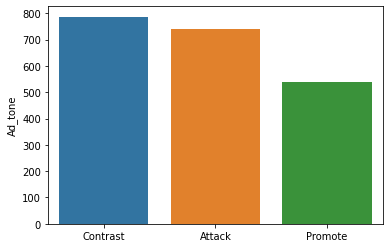

In [36]:
# Class Distribution of Ad tone
x=fb['Ad_tone'].value_counts()
print(x)
sn.barplot(x.index,x)

y= 787+742+538
787/y

### 5. Train and Test data

In [37]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(fb['Text'], fb['Ad_tone'], test_size=0.2)

# label encode Ad_tone (target variable)
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

### 6. Feature Engineering

##### 5.1 Count vectors as features

In [38]:
# create a count vectorize
count_vect = CountVectorizer()
count_vect.fit(fb['Text'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

##### 5.2 Tf-Idf vectors as features

In [39]:
# bigram level Tf-Idf 
tfidf_vect_bigram = TfidfVectorizer(ngram_range=(2,2))
tfidf_vect_bigram.fit(fb['Text'])
xtrain_tfidf_bigram =  tfidf_vect_bigram.transform(train_x)
xvalid_tfidf_bigram =  tfidf_vect_bigram.transform(valid_x)

# trigram level Tf-Idf
tfidf_vect_ngram = TfidfVectorizer(ngram_range=(3,3))
tfidf_vect_ngram.fit(fb['Text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

##### 5.3 Word2Vec vectors as features

In [40]:
# Word2Vec
X_train_tok= [nltk.word_tokenize(i) for i in train_x]  
X_test_tok= [nltk.word_tokenize(i) for i in valid_x]

# bbuild a w2v model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

fb["text_tok"]=[nltk.word_tokenize(i) for i in fb['Text']]
model = Word2Vec(fb['text_tok'],min_count=1)     
modelw = MeanEmbeddingVectorizer(dict(zip(model.wv.index2word, model.wv.syn0)) )
model.wv.index2word

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


### 7. Model Building

In [41]:
# Creating a function for training the model and returning accuracy score
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_valid)
    return metrics.accuracy_score(predictions, valid_y)

##### 6.1 Logistic Regression

In [42]:
# Logistic Regression on Count Vectors
accuracy1 = train_model(linear_model.LogisticRegression(random_state=123), xtrain_count, train_y, xvalid_count)

# Logistic Regression on Bigram Level Tf-Idf vectors
accuracy2 = train_model(linear_model.LogisticRegression(random_state=123), xtrain_tfidf_bigram, train_y, xvalid_tfidf_bigram)

# Logistic Regression on Trigram Level Tf-Idf vectors
accuracy3 = train_model(linear_model.LogisticRegression(random_state=123), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)

# Logistic Regression on Word2Vec vecotrs
accuracy4 = train_model(linear_model.LogisticRegression(random_state=123), X_train_vectors_w2v, train_y,X_val_vectors_w2v)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [43]:
# Accuracy
print ("Logistic Regression, Count Vectors: ", accuracy1)
print ("Logistic Regression, Bigram Vectors: ", accuracy2)
print ("Logistic Regression, N-Gram Vectors: ", accuracy3)
print ("Logistic Regression, Word Embeddings: ", accuracy4)

Logistic Regression, Count Vectors:  0.717391304347826
Logistic Regression, Bigram Vectors:  0.7318840579710145
Logistic Regression, N-Gram Vectors:  0.6980676328502415
Logistic Regression, Word Embeddings:  0.5797101449275363


##### 6.2 XGB Boosting Model


In [44]:
# XGB Boosting on Count vectors
accuracy1 = train_model(xgboost.XGBClassifier(random_state=123), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())

# XGB Boosting on Bigram Level TF IDF vectors
accuracy2 = train_model(xgboost.XGBClassifier(random_state=123), xtrain_tfidf_bigram, train_y, xvalid_tfidf_bigram)

# XGB Boosting on Trigram Level Tf-Idf vectors
accuracy3 = train_model(xgboost.XGBClassifier(random_state=123), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)

# XGB Boosting on Word2Vec vectors
accuracy4 = train_model(xgboost.XGBClassifier(random_state=123), X_train_vectors_w2v, train_y,X_val_vectors_w2v)

In [45]:
# Accuracy
print ("XGB, Count Vectors: ", accuracy1)
print ("XGB, Bigram Vectors: ", accuracy2)
print ("XGB, Trigram Vectors: ", accuracy3)
print ("XGB, Word2Vec vectors: ", accuracy4)

XGB, Count Vectors:  0.7898550724637681
XGB, Bigram Vectors:  0.7246376811594203
XGB, Trigram Vectors:  0.6328502415458938
XGB, Word2Vec vectors:  0.7028985507246377


##### 6.3 Bagging Model (Random Forest)

In [46]:
# Random Forest on Count cectors
accuracy1 = train_model(ensemble.RandomForestClassifier(n_estimators = 200,
                                                    criterion = "entropy",random_state=123), xtrain_count, train_y, xvalid_count)

# Random Forest on Bigram Level TF IDF vectors
accuracy2 = train_model(ensemble.RandomForestClassifier(n_estimators = 200,
                                                    criterion = "entropy",
                                                    random_state=123), xtrain_tfidf_bigram, train_y, xvalid_tfidf_bigram)

# Random Forest on Trigram Level Tf-Idf Vectors
accuracy3 = train_model(ensemble.RandomForestClassifier(n_estimators = 200,
                                                    criterion = "entropy",
                                                    random_state=123), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)

# Random Forest on Word2Vec vectors
accuracy4 = train_model(ensemble.RandomForestClassifier(n_estimators = 200,
                                                    criterion = "entropy",
                                                    random_state=123), X_train_vectors_w2v, train_y,X_val_vectors_w2v)

In [ ]:
# Accuracy
print ("Random Forest, Count Vectors: ", accuracy1)
print ("Random Forest, Bigram Vectors: ", accuracy2)
print ("Random Forest, Trigram Vectors: ", accuracy3)
print ("Random Forest, Word2Vec vectors: ", accuracy4)

Random Forest, Count Vectors:  0.8381642512077294
Random Forest, Bigram Vectors:  0.7753623188405797
Random Forest, Trigram Vectors:  0.6980676328502415
Random Forest, Word2Vec vectors:  0.7318840579710145


### 8. Results of Best-Fitting model

In [47]:
# Plot the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})
    plt.show()
    
# Creating a function for returning the full results of the model
# including classification report and confusion matrix
def results(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_valid)
    print(metrics.classification_report(valid_y, predictions,  digits=5))
    plot_confussion_matrix(valid_y, predictions)

              precision    recall  f1-score   support

           0    0.84828   0.82550   0.83673       149
           1    0.76074   0.78481   0.77259       158
           2    0.80189   0.79439   0.79812       107

    accuracy                        0.80193       414
   macro avg    0.80363   0.80157   0.80248       414
weighted avg    0.80288   0.80193   0.80227       414



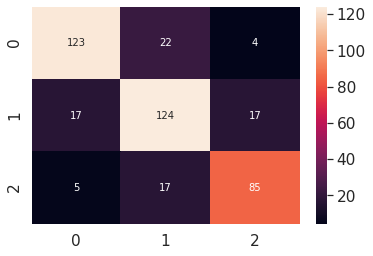

In [48]:
# Results of Random Forest model on Count Vectors
results(ensemble.RandomForestClassifier(n_estimators = 200,
                                        criterion = "entropy",
                                        random_state=123), xtrain_count, train_y, xvalid_count)